In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from torch.utils.data import DataLoader
# Add the path to utils.py
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")

# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *

# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)


# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)

# Function to generate y values
def generate_y(t, is_even):
    if is_even:
        return np.random.normal(0, 0.1 + 2 * (np.cos(np.pi * t) ** 2))
    else:
        return np.random.normal(0, 0.1 + 2 * (np.sin(np.pi * t) ** 2))

# Custom Dataset class to handle MNIST images and simulated data
class SimulatedMNISTDataset(Dataset):
    def __init__(self, mnist_data, positions, y_values, y_noisy, digits, noise_level):
        self.image = mnist_data 
        self.mnist_data = mnist_data
        self.positions = torch.tensor(positions, dtype=torch.float32)
        self.y_values = torch.tensor(y_values, dtype=torch.float32)
        self.y_noisy = torch.tensor(y_noisy, dtype=torch.float32)
        self.digits = torch.tensor(digits, dtype=torch.long)
        self.noise_level = noise_level

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        # Get the image and label from MNIST dataset
        image, _ = self.mnist_data[idx]
        
        # Retrieve the corresponding simulated data
        position = self.positions[idx]
        y_value = self.y_values[idx]
        y_noisy_value = self.y_noisy[idx]
        digit = self.digits[idx]
        
        return image, digit, position, y_value, y_noisy_value
    
    def get_Lim(self):
        self.scale = autoselect_scales_mix_norm(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level)
        )
        
        self.Lim = get_data_loglik_exp(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level),
            scale=self.scale
        )



In [29]:
# Generate the simulated dataset
n_samples = 50000
noise_level = 1
positions = []
y_values = []
digits = []
y_noisy = []

# Ensure unique indices are used
unique_indices = np.random.choice(len(mnist_data), size=n_samples, replace=False)
filtered_mnist_data = torch.utils.data.Subset(mnist_data, unique_indices)

# Run simulation to generate noisy data
for idx in unique_indices:
    image, label = mnist_data[idx]
    t = np.random.uniform(-0.5, 2.5)
    is_even = label % 2 == 0
    y = generate_y(t, is_even)
    noise = np.random.normal(0, noise_level)
    y_noisy_value = y + noise
    positions.append(t)
    y_values.append(y)
    y_noisy.append(y_noisy_value)
    digits.append(label)

positions = np.array(positions)
y_values = np.array(y_values)
y_noisy = np.array(y_noisy)
digits = np.array(digits)
noiseless=y_values
# Create custom dataset with the filtered MNIST dataset and simulated data
simulated_dataset = SimulatedMNISTDataset(
    mnist_data=filtered_mnist_data,
    positions=positions,
    y_values=y_values,
    y_noisy=y_noisy,
    digits=digits,
    noise_level=np.repeat(1, y_noisy.shape[0])
)


In [30]:
simulated_dataset.get_Lim()
L_im = simulated_dataset.Lim
L_im_dim = L_im.shape[1]
input_dim = 784  # MNIST images (28x28)
hidden_dim = 400
latent_dim = 20
position_dim = 1


In [31]:
simulated_dataset.get_Lim()
L_im = simulated_dataset.Lim
L_im_dim = L_im.shape[1]
input_dim = 784  # MNIST images (28x28)
hidden_dim = 400
latent_dim = 20
position_dim = 1


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim + position_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim + position_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)
        
        # Custom likelihood
        self.fc_likelihood = nn.Linear(latent_dim + position_dim, output_dim)
        
    def encode(self, x, pos):
        h = torch.cat([x, pos], dim=1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, pos):
        h = torch.cat([z, pos], dim=1)
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        return torch.sigmoid(self.fc5(h))
    
    def likelihood(self, z, pos):
        h = torch.cat([z, pos], dim=1)
        return F.softmax(self.fc_likelihood(h), dim=1)
    
    def forward(self, x, pos):
        mu, logvar = self.encode(x.view(-1, 784), pos)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, pos), self.likelihood(z, pos), mu, logvar

# Loss function
def loss_function(recon_x, x, likelihood, y_true, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Custom likelihood loss
    log_likelihood = torch.log(torch.sum(torch.exp(y_true) * likelihood, dim=1))
    LIKE = -torch.sum(log_likelihood)
    
    return BCE + KLD + LIKE

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _, pos, y_value, y_noisy) in enumerate(train_loader):
        data, pos, y_value, y_noisy = data.to(device), pos.to(device), y_value.to(device), y_noisy.to(device)
        optimizer.zero_grad()
        recon_batch, likelihood, mu, logvar = model(data, pos.unsqueeze(1))
        loss = loss_function(recon_batch, data, likelihood, y_value.unsqueeze(1), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim, hidden_dim, latent_dim, L_im_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(simulated_dataset, batch_size=128, shuffle=True)

for epoch in range(1, 51):
    train(model, device, train_loader, optimizer, epoch)

# Evaluation
model.eval()
with torch.no_grad():
    test_loader = DataLoader(simulated_dataset, batch_size=128, shuffle=False)
    all_likelihoods = []
    all_positions = []
    all_y_true = []
    all_y_noisy = []
    
    for data, _, pos, y_value, y_noisy in test_loader:
        data, pos = data.to(device), pos.to(device)
        _, likelihood, _, _ = model(data, pos.unsqueeze(1))
        all_likelihoods.append(likelihood.cpu().numpy())
        all_positions.append(pos.cpu().numpy())
        all_y_true.append(y_value.cpu().numpy())
        all_y_noisy.append(y_noisy.cpu().numpy())

all_likelihoods = np.concatenate(all_likelihoods)
all_positions = np.concatenate(all_positions)
all_y_true = np.concatenate(all_y_true)
all_y_noisy = np.concatenate(all_y_noisy)

# Compute posterior mean
est_post = np.zeros(n_samples)
for i in range(n_samples):
    est_post[i] = posterior_mean_norm(
        betahat=np.array([all_y_noisy[i]]),
        sebetahat=np.array([noise_level]),
        log_pi=np.log(all_likelihoods[i, :]),
        scale=simulated_dataset.scale
    ).post_mean

# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 3, 1)
plt.scatter(est_post, all_y_noisy, alpha=0.5, s=1)
plt.title('Est Post vs Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Noisy')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 3, 2)
plt.scatter(est_post, all_y_true, alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(all_y_noisy, all_y_true, alpha=0.5, s=1, label='Y Noisy', color='red')
plt.title('Est Post vs Y True and Y Noisy')
plt.xlabel('Est Post / Y Noisy')
plt.ylabel('Y True')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 3, 3)
plt.scatter(all_positions, all_y_true, alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(all_positions, est_post, alpha=0.5, s=1, label='Est Post', color='red')
plt.scatter(all_positions, all_y_noisy, alpha=0.5, s=1, label='Y Noisy', color='green')
plt.title('Positions vs Est Post, Y True, and Y Noisy')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

# Print statistics
print("\nStatistics:")
print(f"Est Post - Mean: {np.mean(est_post):.4f}, Std: {np.std(est_post):.4f}")
print(f"Y Noisy - Mean: {np.mean(all_y_noisy):.4f}, Std: {np.std(all_y_noisy):.4f}")
print(f"Y True - Mean: {np.mean(all_y_true):.4f}, Std: {np.std(all_y_true):.4f}")

# Calculate and print MSE
mse_noisy = np.mean((all_y_true - all_y_noisy)**2)
mse_est = np.mean((est_post - all_y_true)**2)
print(f"\nMean Squared Error:")
print(f"MSE (Y Noisy vs Y True): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_est:.4f}")

Train Epoch: 1 [0/50000 (0%)]	Loss: 542.453491
Train Epoch: 1 [12800/50000 (26%)]	Loss: 198.349106
Train Epoch: 1 [25600/50000 (51%)]	Loss: 173.965714
Train Epoch: 1 [38400/50000 (77%)]	Loss: 156.879074
====> Epoch: 1 Average loss: 184.1109
Train Epoch: 2 [0/50000 (0%)]	Loss: 141.190659
Train Epoch: 2 [12800/50000 (26%)]	Loss: 140.381348
Train Epoch: 2 [25600/50000 (51%)]	Loss: 132.092239
Train Epoch: 2 [38400/50000 (77%)]	Loss: 125.180786
====> Epoch: 2 Average loss: 134.3314
Train Epoch: 3 [0/50000 (0%)]	Loss: 130.629456
Train Epoch: 3 [12800/50000 (26%)]	Loss: 127.976387
Train Epoch: 3 [25600/50000 (51%)]	Loss: 125.834206
Train Epoch: 3 [38400/50000 (77%)]	Loss: 117.966965
====> Epoch: 3 Average loss: 123.3663
Train Epoch: 4 [0/50000 (0%)]	Loss: 118.929054
Train Epoch: 4 [12800/50000 (26%)]	Loss: 116.909538
Train Epoch: 4 [25600/50000 (51%)]	Loss: 114.564407
Train Epoch: 4 [38400/50000 (77%)]	Loss: 114.773247
====> Epoch: 4 Average loss: 116.8572
Train Epoch: 5 [0/50000 (0%)]	Loss: 

C:\Users\willi\AppData\Local\Temp\ipykernel_27696\4233238138.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_post[i] = posterior_mean_norm(


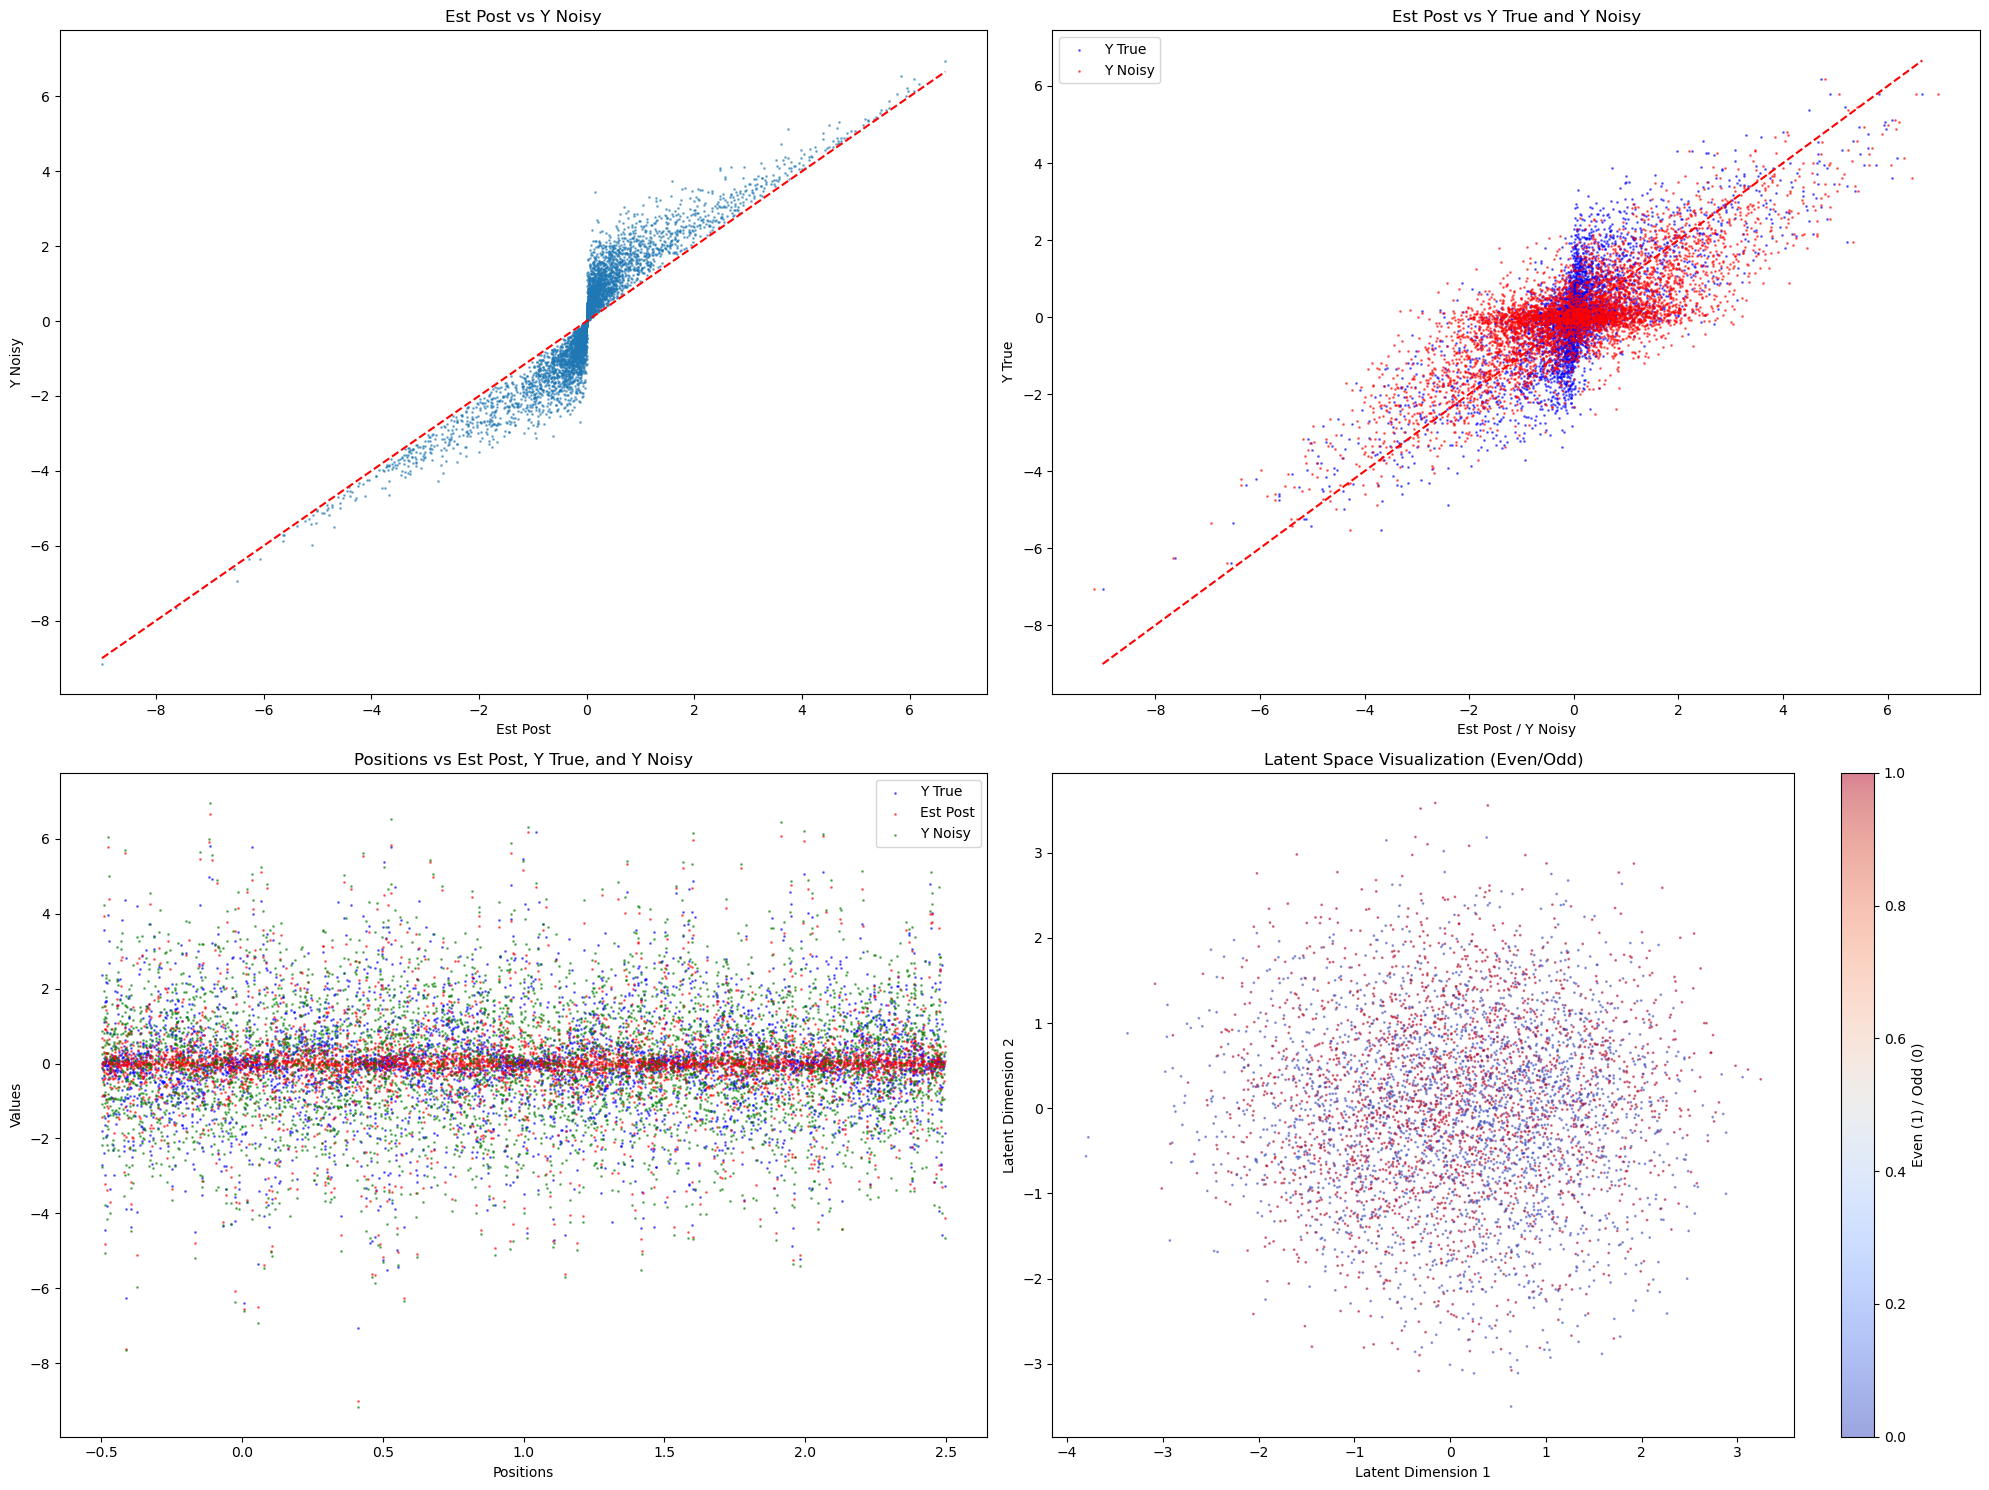

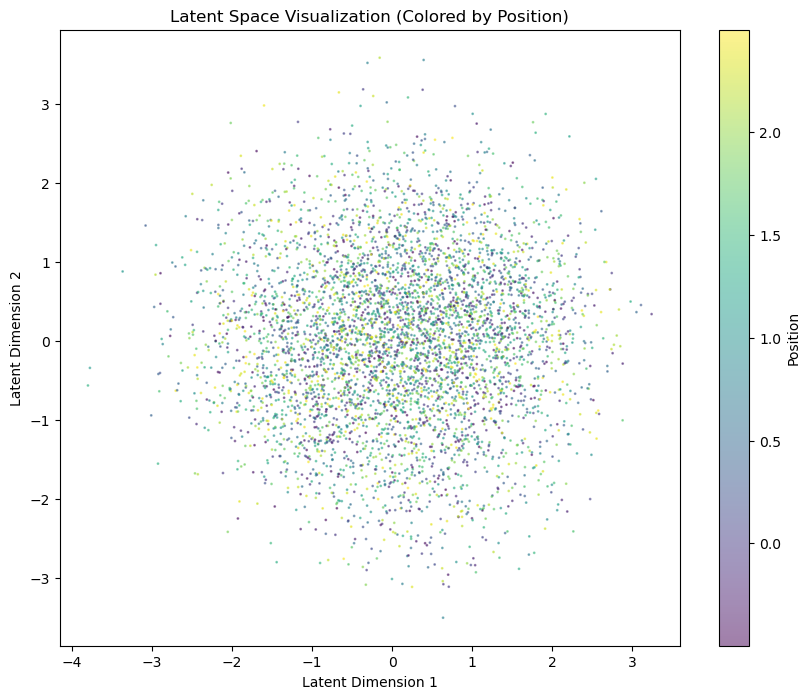


Statistics:
Est Post - Mean: 0.0075, Std: 1.1982
Y Noisy - Mean: 0.0231, Std: 1.6657
Y True - Mean: 0.0076, Std: 1.3122

Mean Squared Error:
MSE (Y Noisy vs Y True): 1.0190
MSE (Est Post vs Y True): 0.7168


In [26]:
# ... [Previous VAE model and training code remains the same] ...

# Evaluation and Plotting
model.eval()
with torch.no_grad():
    test_loader = DataLoader(simulated_dataset, batch_size=128, shuffle=False)
    all_likelihoods = []
    all_positions = []
    all_y_true = []
    all_y_noisy = []
    all_latent = []
    all_digits = []
    
    for data, digits, pos, y_value, y_noisy in test_loader:
        data, pos = data.to(device), pos.to(device)
        mu, logvar = model.encode(data.view(-1, 784), pos.unsqueeze(1))
        z = model.reparameterize(mu, logvar)
        _, likelihood, _, _ = model(data, pos.unsqueeze(1))
        all_likelihoods.append(likelihood.cpu().numpy())
        all_positions.append(pos.cpu().numpy())
        all_y_true.append(y_value.cpu().numpy())
        all_y_noisy.append(y_noisy.cpu().numpy())
        all_latent.append(z.cpu().numpy())
        all_digits.append(digits.numpy())

all_likelihoods = np.concatenate(all_likelihoods)
all_positions = np.concatenate(all_positions)
all_y_true = np.concatenate(all_y_true)
all_y_noisy = np.concatenate(all_y_noisy)
all_latent = np.concatenate(all_latent)
all_digits = np.concatenate(all_digits)

# Compute posterior mean
est_post = np.zeros(n_samples)
for i in range(n_samples):
    est_post[i] = posterior_mean_norm(
        betahat=np.array([all_y_noisy[i]]),
        sebetahat=np.array([noise_level]),
        log_pi=np.log(all_likelihoods[i, :]),
        scale=simulated_dataset.scale
    ).post_mean

# Plotting
plt.figure(figsize=(20, 15))

# Plot 1: Est Post vs Y Noisy
plt.subplot(2, 2, 1)
plt.scatter(est_post, all_y_noisy, alpha=0.5, s=1)
plt.title('Est Post vs Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Noisy')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(2, 2, 2)
plt.scatter(est_post, all_y_true, alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(all_y_noisy, all_y_true, alpha=0.5, s=1, label='Y Noisy', color='red')
plt.title('Est Post vs Y True and Y Noisy')
plt.xlabel('Est Post / Y Noisy')
plt.ylabel('Y True')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(2, 2, 3)
plt.scatter(all_positions, all_y_true, alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(all_positions, est_post, alpha=0.5, s=1, label='Est Post', color='red')
plt.scatter(all_positions, all_y_noisy, alpha=0.5, s=1, label='Y Noisy', color='green')
plt.title('Positions vs Est Post, Y True, and Y Noisy')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()

# Plot 4: Latent Space Visualization (Even/Odd)
plt.subplot(2, 2, 4)
is_even = all_digits % 2 == 0
scatter = plt.scatter(all_latent[:, 0], all_latent[:, 1], c=is_even, cmap='coolwarm', alpha=0.5, s=1)
plt.colorbar(scatter, label='Even (1) / Odd (0)')
plt.title('Latent Space Visualization (Even/Odd)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

plt.tight_layout()
plt.show()

# Additional plot: Latent space colored by position
plt.figure(figsize=(10, 8))
scatter = plt.scatter(all_latent[:, 0], all_latent[:, 1], c=all_positions, cmap='viridis', alpha=0.5, s=1)
plt.colorbar(scatter, label='Position')
plt.title('Latent Space Visualization (Colored by Position)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

# Print statistics
print("\nStatistics:")
print(f"Est Post - Mean: {np.mean(est_post):.4f}, Std: {np.std(est_post):.4f}")
print(f"Y Noisy - Mean: {np.mean(all_y_noisy):.4f}, Std: {np.std(all_y_noisy):.4f}")
print(f"Y True - Mean: {np.mean(all_y_true):.4f}, Std: {np.std(all_y_true):.4f}")

# Calculate and print MSE
mse_noisy = np.mean((all_y_true - all_y_noisy)**2)
mse_est = np.mean((est_post - all_y_true)**2)
print(f"\nMean Squared Error:")
print(f"MSE (Y Noisy vs Y True): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_est:.4f}")